In [1]:
#https://samdsblog.netlify.app/post/visualizing-volcano-plots-in-r/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from adjustText import adjust_text

In [2]:
#Abro el .xlsx y selecciono las hojas, filas y columnas que me interesen. En este caso la de p-péptidos
file=pd.ExcelFile('Quantification_TMT-phospho_4conditions-mouse.xlsx')
#cargo la hoja de p-péptidos
df_sheet=file.parse('Peptide-groups_phosho_FDR<1%')

In [3]:
#Función para obtener la lista de modificaciones de cada proteína y la posición en la tabla de las proteínas sin modificación identificada
def get_mod_sites(df_sheet):
    cols=['Modifications','Master Protein Accessions','Master Protein Descriptions','Modifications in Proteins']
    df=df_sheet[cols]
    #print(df)
    pattern1=r'(?<=\[| )[STY]\d+' #que aparezca S, T o Y con "[" o un " " antes *y* seguida de algún número (eso significa que se ha podido reconocer el sitio en la proteína y va a aparecer en la columna de Modifications in Proteins)
    pattern2=r'[STY/](?![a-zA-Z0-9])' #que aparezca "/" o S, T, Y *sin* estar seguida de números (esto significa que no se ha podido reconocer el sitio concreto de fosforilación)
    accession=''
    sites_list=[]
    #match_count=1
    row_count=0 #quiero saber en qué fila estoy
    n_i_rows=[] #una lista para recopilar qué filas no tienen una posición concreta asignada
    n_i_accs=[] #lista para recopilar las accesiones/genes sin posición concreta
    skipped_count=0
    for index,row in df.iterrows():
        match1=re.search(pattern1, row['Modifications'])
        match2=re.search(pattern2, row['Modifications'])
        if isinstance(row['Master Protein Descriptions'], float):
            n_i_rows.append(row_count)
            n_i_name="Not identified"
            row_count=row_count+1
            n_i_accs.append(n_i_name)
            continue
        elif "GN=" not in row['Master Protein Descriptions']: #si una de las filas no tiene el nombre del gen
            n_i_rows.append(row_count) #añado la fila en la que no hay GN
            row_count=row_count+1 
            n_i_name=row['Master Protein Descriptions'].split(" OS")[0] #ej.: Splicing factor C9orf78 homolog OS=Mus musculus OX=10090 PE=1 SV=2
            n_i_accs.append(n_i_name)
            skipped_count=skipped_count+1
        elif not match1 and match2:
            n_i_rows.append(row_count) #añado la fila en la que no hay posición exacta de fosforilación
            row_count=row_count+1
            accession=(row['Master Protein Accessions'].split(';')[0])
            #print(accession)
            n_i_accs.append(accession) #añado la accesión que no tiene posición exacta de fosforilación
            #epnd='(epnd)'#"exact position not determined"
            #sites_list.append(epnd)
            #match_count=match_count+1
            skipped_count=skipped_count+1
        elif match1:
            row_count=row_count+1
            accession=(row['Master Protein Accessions'].split(';')[0])
            #print(accession)
            prots_sites_list=row['Modifications in Proteins'].split('];')
            #match_count=match_count+1
            #print(prots_sites_list)
            for element in prots_sites_list:
                if accession in element:
                    matches=re.findall(pattern1, element)
                    #print(matches)
                    if len(matches)==1:
                        sites='('+matches[0]+')'
                    elif len(matches)>1: 
                        site_count=0
                        #print(len(matches))
                        for site in matches:
                            #print(site_count)
                            if site_count==0:
                                sites='('+matches[site_count]+','
                            elif site_count!=0 and site_count!=len(matches)-1:
                                sites=sites+matches[site_count]+','
                            elif site_count==len(matches)-1:
                                sites=sites+matches[site_count]+')'
                            site_count=site_count+1
                    sites_list.append(sites)
        else:
            break
    #print(row_count)
    perc_n_i=(round(100*len(n_i_accs)/row_count,2))
    return sites_list, n_i_rows, n_i_accs, perc_n_i, row_count #match_count debe coincidir con la cantidad de filas en Excel, si no, algo no ha salido bien (revisar)
sites_list, n_i_rows, n_i_accs, perc_n_i, row_count=get_mod_sites(df_sheet)
print(sites_list)
print(len(sites_list))
print('\n'+'Accessions/genes where the exact phosphorylation site has not been identified'+' ('+str(len(n_i_accs))+', '+str(perc_n_i)+'%):'+'\n'+str(n_i_accs))#+'Son '+str(len(n_i_accs))+' y representan un '+str(perc_n_i)+'% de las proteínas.'+'\n')
#print(n_i_accs) #simplemente necesito el número de la fila (la de Excel - 2) de los que no tienen GN o modificación exacta para evitar meter esa fila en un nuevo df
#print(perc_n_i)
#print('Sites count: '+str(match_count))
print(n_i_rows)
print(row_count)

['(S696)', '(S53)', '(S36)', '(S384)', '(S402)', '(S5555)', '(S85)', '(S53)', '(S181)', '(S504)', '(S491)', '(S614)', '(S58)', '(S985)', '(S140)', '(S18)', '(S18)', '(S250)', '(S1547)', '(S687)', '(S297)', '(S4)', '(S425)', '(S67,S74)', '(S307)', '(S225)', '(S19)', '(S77)', '(S153)', '(S248)', '(S913)', '(T282)', '(S18)', '(S341)', '(T269)', '(S1547)', '(S194)', '(S194)', '(S504)', '(S271)', '(S159)', '(S114)', '(S151)', '(S1071)', '(S31,S33)', '(S75)', '(T262)', '(S141)', '(S2476)', '(S215)', '(S284)', '(S595)', '(S160)', '(S434)', '(S434)', '(S17)', '(S534)', '(S522)', '(T727)', '(S912)', '(S126,S130)', '(S199)', '(S1481)', '(S696)', '(S864)', '(S86)', '(S250)', '(S434)', '(S164)', '(S164)', '(S18)', '(S416)', '(S1070)', '(S14)', '(S43)', '(S1915)', '(S289,S297)', '(S659)', '(S349)', '(S189)', '(S82)', '(S639)', '(S432)', '(S135)', '(T163)', '(S1025)', '(S1089)', '(S196)', '(S510)', '(S510)', '(S181)', '(S228,S234)', '(S434)', '(S116)', '(S140)', '(S1054)', '(S1104)', '(S205)', '(S11

In [4]:
#Función para crear un df que contenga solo las filas con sitios concretos
def get_new_df(df_sheet):
    col_names=[] #quiero un nuevo df con las mismas columnas que el original; inicio una lista para añadir los nombres de las columnas del df original
    for name in df_sheet.columns: #añado el nombre de cada columna del df a la lista de nombres
        col_names.append(name)
    new_df=pd.DataFrame(columns=col_names)
    #print(new_df)
    new_row_count=0 #inicio un contador de filas para saber en qué fila del df estamos
    for index,row in df_sheet.iterrows():
        if new_row_count in n_i_rows:
            #print(row)
            new_row_count=new_row_count+1
        elif new_row_count not in n_i_rows:
            #print(row)
            new_df.loc[new_row_count]=row
            new_row_count=new_row_count+1
        else:
            break
        #print(new_row_count)
    new_df=new_df.reset_index(drop=True) #quitamos el index del df anterior. Al añadir filas de otro df, el index se queda, por lo que hay que reiniciarlo para que después no haya problemas
    return new_df
new_df=get_new_df(df_sheet)
#new_df

In [5]:
#Genero un df para cada comparación seleccionando las columnas 5-8 y las dos correspondientes al log2(ratio abundancias) de cada condición y su adj. p-value
#iloc[:] selecciona todas las filas para después seleccionar las columnas que queramos
df_cA_cC=new_df.iloc[:, [5,6,8,16,28]] #Cre AKI/Cre Ctrl
df_nA_nC=new_df.iloc[:, [5,6,8,20,32]] #Napi AKI/Napi Ctrl
df_cA_nC=new_df.iloc[:, [5,6,8,19,31]] #Cre AKI/Napi Ctrl
df_nA_cA=new_df.iloc[:, [5,6,8,15,27]] #Napi AKI/Cre AKI
df_nA_cC=new_df.iloc[:, [5,6,8,17,29]] #Napi AKI/Cre Ctrl
df_nC_cC=new_df.iloc[:, [5,6,8,18,30]] #Napi Ctrl/Cre Ctrl
dfs_list=[df_cA_cC,df_nA_nC,df_cA_nC,df_nA_cA,df_nA_cC,df_nC_cC]
#dfs_list[5]

In [6]:
def get_fc_dfs(five_cols_df):
    #Quiero un nuevo df para las p-prot. con mayor FC y menor p-value, con las mismas columnas que el df original de 5 columnas; un df también para las p-prot. de menor FC y menor p-value
    #Esto lo necesito para después poder poner de otro color *y con los nombres* las top upreg y top downreg
    #Recordatorio de cómo funciona log2(fold change): log2(1) = 0 [no hay diferencia de expresión]; log2(2)=1 ["1" significa que hay EL DOBLE de expresión]; log2(0.5)=-1 ["-1" es LA MITAD de expresión]
    col_names=[] #inicio una lista para añadir los nombres de las columnas del df original de 5 cols
    for name in five_cols_df.columns: #añado el nombre de cada columna del df a la lista de nombres de cols
        col_names.append(name)
    top_upreg_df=pd.DataFrame(columns=col_names)
    top_downreg_df=pd.DataFrame(columns=col_names)
    #Como los nombres del resto de p-prot. no me interesan tanto, extraigo solo sus FCs y adj. p-values
    fc_list_bottom=[] #creo una lista para los FCs que no entran dentro del top
    top_upreg_fcs=[] #lista con los top FCs
    top_downreg_fcs=[]
    pval_list_bottom=[] #lista para los adj. p-values que no entran dentro del top
    top_upreg_pvals=[]
    top_downreg_pvals=[]
    row_count=0
    top_rows=[] #inicio una lista donde guardo la posición de las filas que se guardan en top
    for index,row in five_cols_df.iterrows():
        row.iloc[4]=-np.log10(row.iloc[4]) #aplico -log10(adj. p-value) [que está en la 5ª columa, 4ª si empezamos a contar desde 0 en lugar de 1]
        if row.iloc[3]>=1 and row.iloc[4]>=2: #si el log2(FC) >= 1 (doble o más de abundacia) y -log10(adj. p-value)>= 2 (adj. p-value <= 0.01), la p-prot. entra dentro de las "top upreg"
            top_upreg_df.loc[row_count]=row #añado la fila al df
            top_rows.append(row_count) #añado el número de fila a la lista 
        elif row.iloc[3]<=-1 and row.iloc[4]>=2: #si el log2(FC) <= -1 (la mitad o menos de abundacia) y -log10(adj. p-value)>= 2 (adj. p-value <= 0.01), la p-prot. entra dentro de las "top downreg"
            top_downreg_df.loc[row_count]=row
            top_rows.append(row_count)
        elif row_count not in top_rows: #las filas que no están en top up-/downreg se añaden como "bottom"
            fc_list_bottom.append(row.iloc[3]) #añado el FC a la lista; el FC se encuentra en la columna "4" (siendo "0" la primera columna)
            pval_list_bottom.append(row.iloc[4]) #añado el adj. p-value a la lista            
        row_count+=1
    #Ordeno los nuevos dfs según el FC: el upreg de mayor a menor FC (así tengo los más altos al principio) y el downreg de menor a mayor FC (al revés porque los que más cambian son negativos al estar en log2)
    top_upreg_df=top_upreg_df.sort_values(by=col_names[3], ascending=False) #ascending=False: de mayor a menor (tengo primero los que más cambian)
    top_upreg_df=top_upreg_df.reset_index(drop=True)
    for index,row in top_upreg_df.iterrows():
        top_upreg_fcs.append(row.iloc[3]) #añado el FC
        top_upreg_pvals.append(row.iloc[4]) #añado el adj. p-value
    #Repito lo mismo para downreg:
    top_downreg_fcs=[] #lista para los top FCs
    top_downreg_pvals=[] #lista para los top adj. p-values
    top_downreg_df=top_downreg_df.sort_values(by=col_names[3], ascending=True) #ascending=True: de menor a mayor (tengo primero los que más cambian, que al ser downreg y estar en log2, son negativos)
    top_downreg_df=top_downreg_df.reset_index(drop=True)
    for index,row in top_downreg_df.iterrows():
        top_downreg_fcs.append(row.iloc[3]) #añado el FC
        top_downreg_pvals.append(row.iloc[4]) #añado el adj. p-value
    return fc_list_bottom, pval_list_bottom, top_upreg_fcs, top_upreg_pvals, top_downreg_fcs, top_downreg_pvals, top_upreg_df, top_downreg_df
fc_list_bottom, pval_list_bottom, top_upreg_fcs, top_upreg_pvals, top_downreg_fcs, top_downreg_pvals, top_upreg_df, top_downreg_df=get_fc_dfs(df_nC_cC)

In [7]:
#Extraigo las modificaciones en la top df
def get_top_mod_sites(top_df):
    pattern1=r'(?<=\[| )[STY]\d+' #que aparezca S, T o Y con "[" o un " " antes *y* seguida de algún número (eso significa que se ha podido reconocer el sitio en la proteína y va a aparecer en la columna de Modifications in Proteins)
    accession=''
    sites_list=[]
    row_count=0 #quiero saber en qué fila estoy
    for index,row in top_df.iterrows():
        row_count=row_count+1
        accession=(row['Master Protein Accessions'].split(';')[0])
        #print(accession)
        prots_sites_list=row['Modifications in Proteins'].split('];')
        #match_count=match_count+1
        #print(prots_sites_list)
        for element in prots_sites_list:
            if accession in element:
                matches=re.findall(pattern1, element)
                #print(matches)
                if len(matches)==1:
                    sites='('+matches[0]+')'
                elif len(matches)>1: 
                    site_count=0
                    #print(len(matches))
                    for site in matches:
                        #print(site_count)
                        if site_count==0:
                            sites='('+matches[site_count]+','
                        elif site_count!=0 and site_count!=len(matches)-1:
                            sites=sites+matches[site_count]+','
                        elif site_count==len(matches)-1:
                            sites=sites+matches[site_count]+')'
                        site_count=site_count+1
                sites_list.append(sites)
    #print(row_count)
    #perc_n_i=(round(100*len(n_i_accs)/row_count,2))
    return sites_list #match_count debe coincidir con la cantidad de filas en Excel, si no, algo no ha salido bien (revisar)
sites_list=get_top_mod_sites(top_upreg_df)
print(sites_list)
#print(row_count)

['(T1640)', '(S148)']


In [8]:
#Extraigo los nombres de los genes de la top df
def get_gene_names(top_df):
    descripts_list=top_df['Master Protein Descriptions'].tolist()
    gene_names=[]
    descript_count=1
    for descript in descripts_list:
        #print(descript)
        gene=descript.split("GN=")[1].split(' ')[0]
        gene_names.append(gene)
        descript_count=descript_count+1
    #print(gene_names)
    #print(descript_count)
    return gene_names, descript_count
#gene_names,descript_count=get_gene_names(top_upreg_df)
#print(gene_names)
#print(len(gene_names))

In [9]:
#Junto los nombres de los genes con las modificaciones
def get_genes_w_mods(top_df):
    genes_w_mods=[]
    mod_counter=0
    for name in gene_names:
        mod=sites_list[mod_counter]
        gene_w_mods=name+' '+mod
        genes_w_mods.append(gene_w_mods)
        mod_counter=mod_counter+1
    return genes_w_mods
#genes_w_mods=get_genes_w_mods(top_upreg_df)
#print(genes_w_mods)

['Eif4b (S425)', 'Akap12 (S504)', 'Apoa4 (S333)', 'Spp1 (S228,S234)', 'Cav2 (S20,S23)', 'Ahsg (S20,S23)', 'Jpt1 (S77)', 'Ncf2 (S332)', 'Atf3 (T162)', 'Spp1 (S250)', 'Ahsg (S250)', 'Ahnak (S5555)', 'Spp1 (S271)', 'Atxn2l (S687)', 'Rtn4 (S687)', 'Ttr (S72)', 'Mapt (S696)', 'Shank3 (S985)', 'Ces2e (S552)', 'Lrrfip1 (S614)', 'Eif4b (S504)', 'Bcar1 (S432)', 'Ahnak (S4890)', 'Spp1 (S250)', 'Lad1 (S328)', 'Irf2bp1 (S384)', 'Sgta (S307)', 'Agfg1 (S181)', 'Ptpn12 (S673)', 'Cobll1 (S993)', 'Ubxn6 (S36)', 'Lad1 (S434)', 'Mapt (S491)', 'Septin9 (S85)', 'Sqstm1 (T269)', 'Spp1 (S283)', 'Ndrg1 (S336,S342)', 'Akap12 (S533)', 'Akap12 (S533,S535)', 'Kiaa1522 (S402)', 'Ksr1 (S317)', 'Thrap3 (S248)', 'Sec23ip (S735)', 'Plin1 (S433,S439)', 'Rbm14 (S215)', 'Synpo (S230)', 'Akap12 (S533)', 'Tns1 (S1547)', 'Hspb1 (S15)', 'Rad23a (S123)', 'Abi1 (S225)', '1110004F10Rik (S17)', 'Eif3b (S75)', 'Pakap (S809)', 'Spp1 (S212)', 'Bclaf1 (S289)', 'Nsfl1c (S114)']
[3.37, 3.13, 2.78, 2.78, 2.55, 2.51, 2.5, 2.47, 2.47, 2.

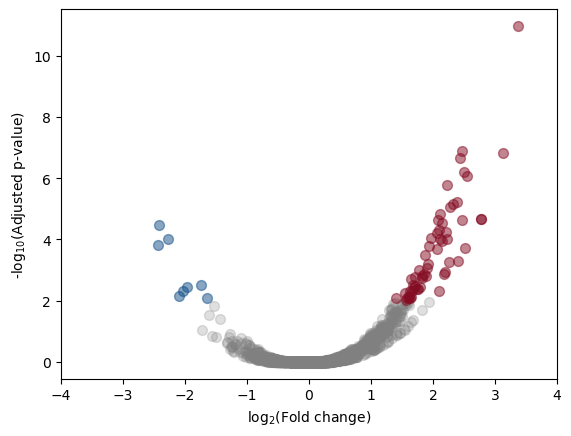

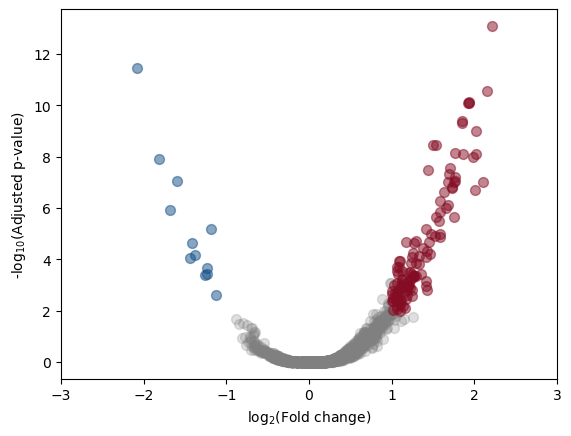

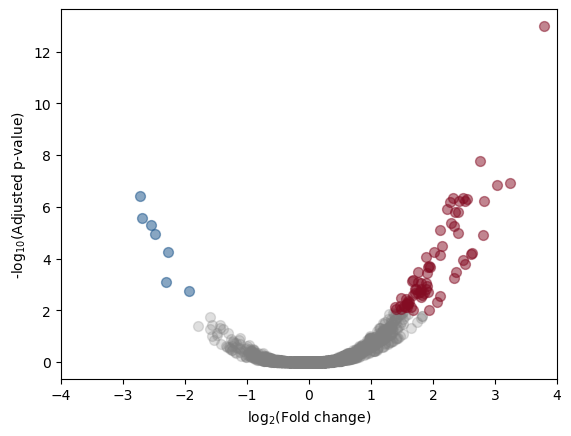

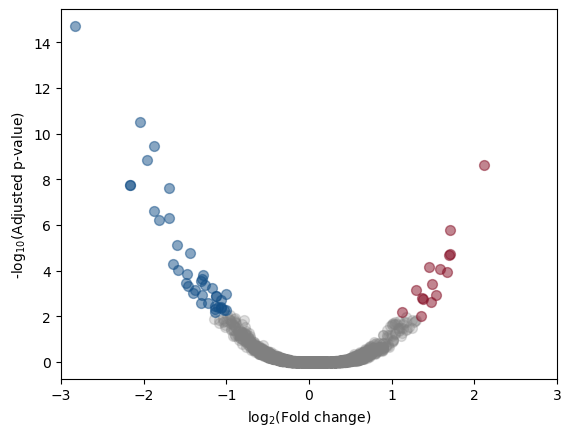

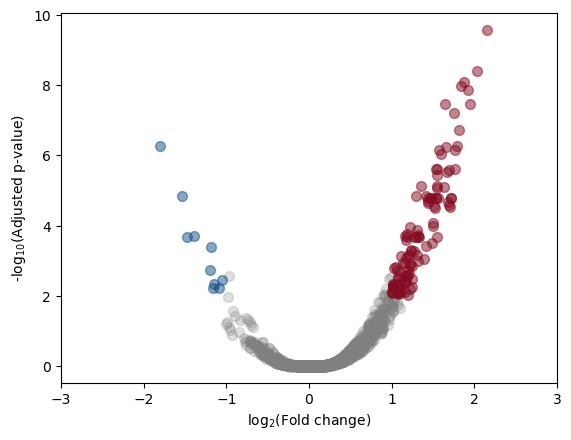

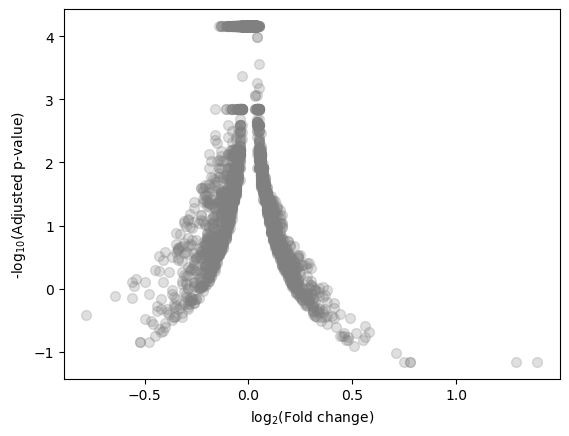

In [10]:
for i,five_cols_df in enumerate(dfs_list):
    fc_list_bottom, pval_list_bottom, top_upreg_fcs, top_upreg_pvals, top_downreg_fcs, top_downreg_pvals, top_upreg_df, top_downreg_df=get_fc_dfs(five_cols_df)
    #Extraigo los labels para las top upreg p-prot. 
    sites_list=get_top_mod_sites(top_upreg_df)
    gene_names,descript_count=get_gene_names(top_upreg_df)
    genes_w_mods=get_genes_w_mods(top_upreg_df)
    top_upreg_genes_w_mods=genes_w_mods
    print(top_upreg_genes_w_mods)
    print(top_upreg_fcs)
    print(str(len(top_upreg_fcs))+"\n")
    #Extraigo los labels para las top downreg p-prot. 
    sites_list=get_top_mod_sites(top_downreg_df)
    gene_names,descript_count=get_gene_names(top_downreg_df)
    genes_w_mods=get_genes_w_mods(top_downreg_df)
    top_downreg_genes_w_mods=genes_w_mods
    print(top_downreg_genes_w_mods)
    print(top_downreg_fcs)
    print(str(len(top_downreg_fcs))+"\n")
    #Creo un bubble plot
    #Primero uso los valores "bottom". x: fc_list_bottom; y: pval_list_bottom
    plt.figure() #Inicio un gráfico
    #Creo un bubble plot con valores x, y, tamaño, color, transparencia
    plt.scatter(fc_list_bottom, pval_list_bottom, s=50, color='grey', alpha=0.25)
    plt.scatter(top_upreg_fcs, top_upreg_pvals, s=50, color='#840c23', alpha=0.5)
    plt.scatter(top_downreg_fcs, top_downreg_pvals, s=50, color='#134f87', alpha=0.5)
    #Escojo los límites del eje x 
    if top_downreg_fcs: #si la lista no está vacía
        x_lim=max(top_upreg_fcs[0],-top_downreg_fcs[0]) #selecciono el mayor |FC| entre upreg y downreg 
        x_lim=math.ceil(x_lim) #math.ceil() pasa el número al siguiente entero (ej. 2.1 -> 3)
        plt.xlim(-x_lim,x_lim)
    ## 
    #Intento de añadir los nombres de los genes (pero se solapan con plt.annotate y si uso labels, labels.append y adjust_text, no se reconoce bien a qué punto está asociado)
    #Añado los nombres de los 10 valores de FC más grandes (que son los 10 primeros en la lista de FCs y también en la lista de nombres)
    #labels_num= min(10, len(top_upreg_genes_w_mods)) #quiero seleccionar cuántos nombres quiero poner. min() devuelve el menor de los valores que hay en el paréntesis. En este caso si len>10, devuelve 10 (porque es el menor); si len<10 (ej. solo hay 2 genes), entonces devuelve el otro valor (2)
    #labels=[]
    #for i in range(labels_num):  # Only label the first 10 points
        #plt.annotate(top_upreg_genes_w_mods[i], (top_upreg_fcs[i], top_upreg_pvals[i]), textcoords="offset points", xytext=(5,0), ha='left', fontsize=6)
    #    labels.append(plt.text(top_upreg_fcs[i], top_upreg_pvals[i], top_upreg_genes_w_mods[i], fontsize=6))
    #adjust_text(labels)
    ##
    plt.xlabel('log$_{2}$(Fold change)')
    plt.ylabel('-log$_{10}$(Adjusted p-value)')
    plt.savefig(f"volcano_plot_{i}.png")
    plt.show
print(plt.rcParams['font.sans-serif']) #para saber qué fuente usar para añadir los nombres de los genes

In [ ]:
#1) Con get_mod_sites y get_new_df saco new_df, que es toda la tabla quitando las filas donde no hay gen/modificación identificados
#2) Tengo también un df para cada comparación que incluye: Modifications	Accessions	Gene	Abundance Ratio (log2)	Adj. P-Value
#for df in dfs_list: #para cada df de cada comparación